In [1]:
import pandas as pd

from tms_risk.utils import get_subjects, get_tms_conditions
from tqdm.contrib.itertools import product
import seaborn as sns
import pingouin
import numpy as np
import matplotlib.pyplot as plt
import os.path as op

bids_folder  = '/data/ds-tmsrisk'

stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']

In [2]:
subjects = get_subjects(all_tms_conditions=True)

In [3]:
pars = []
keys = []

for sub, session, roi in product(subjects, [1,2,3], ['NPCr2cm-cluster']):

    try:
        pars.append(sub.get_prf_parameters_volume(session, smoothed=True, retroicor=False, denoise=True, cross_validated=False, natural_space=True, roi=roi))
        keys.append((sub.subject, session, roi))
    except Exception as e:
        print(e)

pars = pd.concat(pars, keys=keys, names=['subject', 'session', 'roi'])
tms_conditions = get_tms_conditions()
for key in tms_conditions:
    tms_conditions[key][1] = 'baseline'

pars['stimulation_condition'] = pars.reset_index().apply(lambda d: tms_conditions[d['subject']][d['session']],  axis=1).values
pars = pars.set_index('stimulation_condition', append=True)
pars.index = pars.index.set_names('voxel', level=-2)


  0%|          | 0/105 [00:00<?, ?it/s]

In [4]:
pars_ = pars.copy()

* Find distribution of mus
* Find amplitudes as function of mus
* Find R2 as a function of mus

# Use only pars with CVr > 0.0 _within session_ and then see effect of brain sitmulation

In [82]:
thr_pars = pars[pars.cvr2 > 0.0]

tmp = thr_pars.groupby(['subject', 'stimulation_condition']).mean().stack().to_frame('value')

In [84]:
pingouin.pairwise_tests(data=tmp2.reset_index(), dv='value', between='stimulation_condition', within='subject')

TypeError: 'NoneType' object is not callable

                  Source  ddof1  ddof2         F     p-unc       ng2  eps
0  stimulation_condition      1     33  7.324106  0.010686  0.060369  1.0


TypeError: 'NoneType' object is not callable

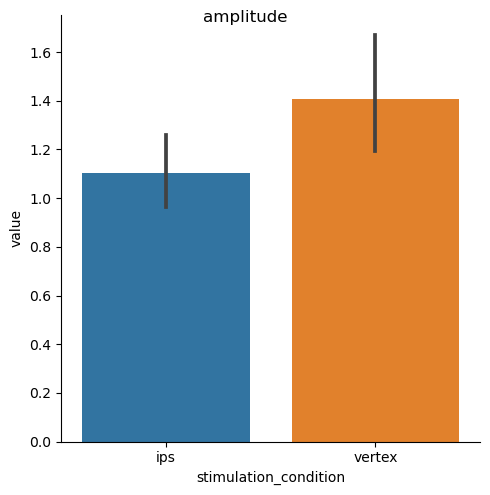

In [83]:
for par, tmp2 in tmp.drop('baseline', level='stimulation_condition').groupby('parameter'):
    #  tmp.drop('baseline', level='stimulation_condition').xs('amplitude', 0, 'parameter').groupby(['subject', 'stimulation_condition']).mean().reset_index()

    ax = sns.catplot(x='stimulation_condition', y='value', data=tmp2.reset_index(), kind='bar')
    plt.gcf().suptitle(par)
    print(pingouin.rm_anova(tmp2.reset_index(), 'value', 'stimulation_condition', 'subject'))
    print(pingouin.pairwise_tests(data=tmp2.reset_index(), dv='value', between='stimulation_condition', within='subject'))

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


KeyError: 'value'

,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,stimulation_condition,1,34,3.019308,0.09133,0.028887,1.0


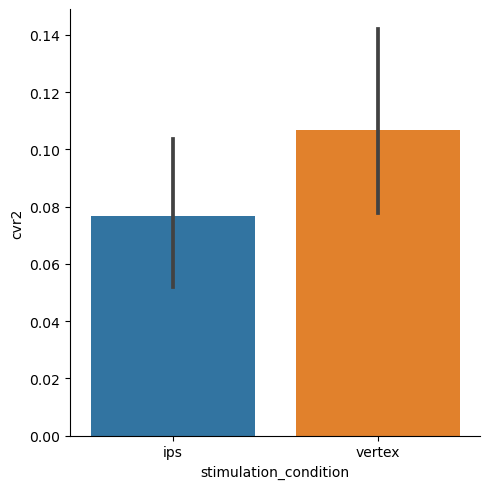

In [75]:
tmp = (pars['cvr2'] > 0.0).drop('baseline', level='stimulation_condition').groupby(['subject', 'stimulation_condition']).mean().reset_index()

sns.catplot(x='stimulation_condition', y='cvr2', data=tmp.reset_index(), kind='bar')

pingouin.rm_anova(tmp, 'cvr2', 'stimulation_condition', 'subject')

# Use first session to select voxels

In [68]:
thr_pars = pars.droplevel('session').droplevel('Stimulation condition').unstack('stimulation_condition')
thr_pars = thr_pars[thr_pars[('cvr2', 'baseline')] > 0.0].stack('stimulation_condition')

tmp = thr_pars.groupby(['subject', 'stimulation_condition']).mean().stack().to_frame('value')

                  Source  ddof1  ddof2         F     p-unc       ng2  eps
0  stimulation_condition      1     34  0.746469  0.393651  0.011242  1.0
                  Source  ddof1  ddof2         F     p-unc       ng2  eps
0  stimulation_condition      1     34  0.698493  0.409126  0.005804  1.0
                  Source  ddof1  ddof2         F     p-unc       ng2  eps
0  stimulation_condition      1     34  0.000137  0.990738  0.000001  1.0
                  Source  ddof1  ddof2         F    p-unc       ng2  eps
0  stimulation_condition      1     34  2.239858  0.14372  0.020081  1.0
                  Source  ddof1  ddof2         F     p-unc     ng2  eps
0  stimulation_condition      1     34  3.907283  0.056234  0.0143  1.0
                  Source  ddof1  ddof2        F     p-unc       ng2  eps
0  stimulation_condition      1     34  0.04187  0.839088  0.000635  1.0


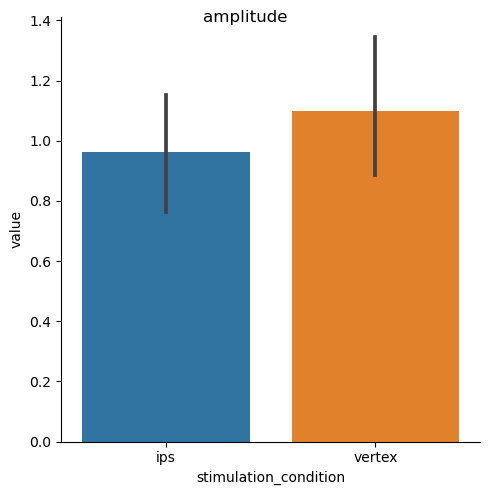

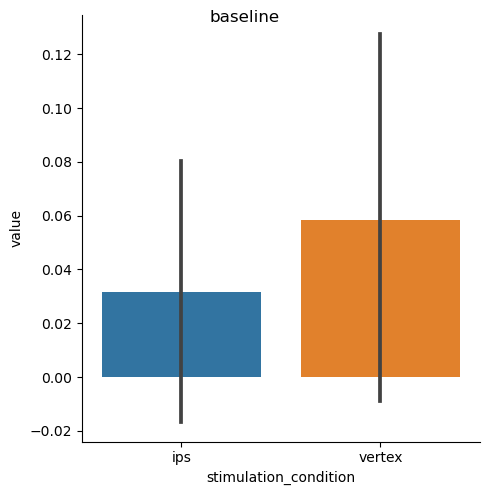

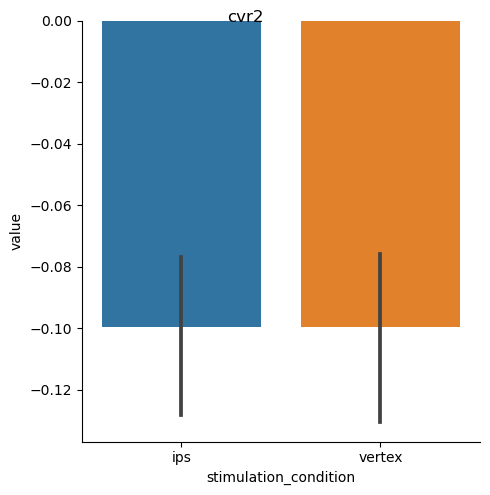

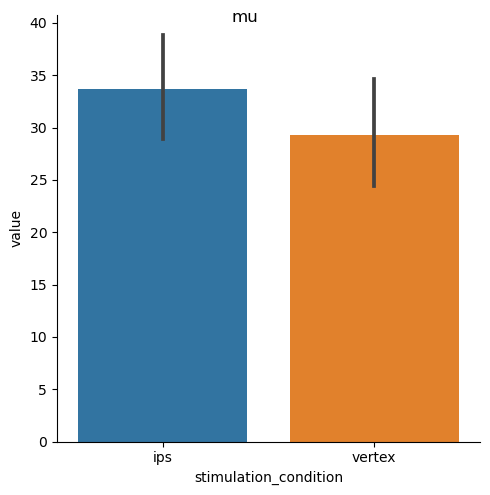

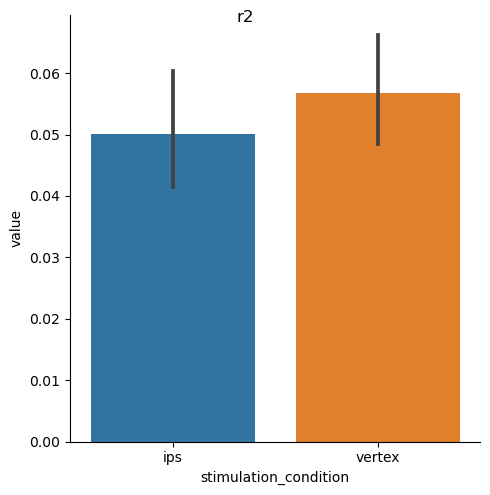

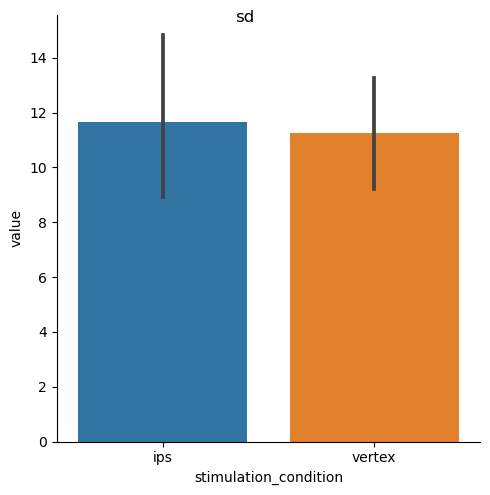

In [69]:
for par, tmp2 in tmp.drop('baseline', level='stimulation_condition').groupby('parameter'):
    #  tmp.drop('baseline', level='stimulation_condition').xs('amplitude', 0, 'parameter').groupby(['subject', 'stimulation_condition']).mean().reset_index()

    ax = sns.catplot(x='stimulation_condition', y='value', data=tmp2.reset_index(), kind='bar')
    plt.gcf().suptitle(par)
    print(pingouin.rm_anova(tmp2.reset_index(), 'value', 'stimulation_condition', 'subject'))

In [5]:
pars['Stimulation condition'] = pars.index.get_level_values('stimulation_condition').map({'vertex': 'Vertex', 'baseline': 'Baseline', 'ips': 'IPS'})
pars = pars.set_index('Stimulation condition', append=True)

% CVR2>0
subject stimulation_condition roi                      
01      baseline              NPCr2cm-cluster  0.239024
        ips                   NPCr2cm-cluster  0.056098
        vertex                NPCr2cm-cluster  0.143902
02      baseline              NPCr2cm-cluster  0.024272
        ips                   NPCr2cm-cluster  0.014563
...                                                 ...
72      ips                   NPCr2cm-cluster  0.225728
        vertex                NPCr2cm-cluster  0.041262
74      baseline              NPCr2cm-cluster  0.207161
        ips                   NPCr2cm-cluster  0.043478
        vertex                NPCr2cm-cluster  0.089514

[105 rows x 1 columns]

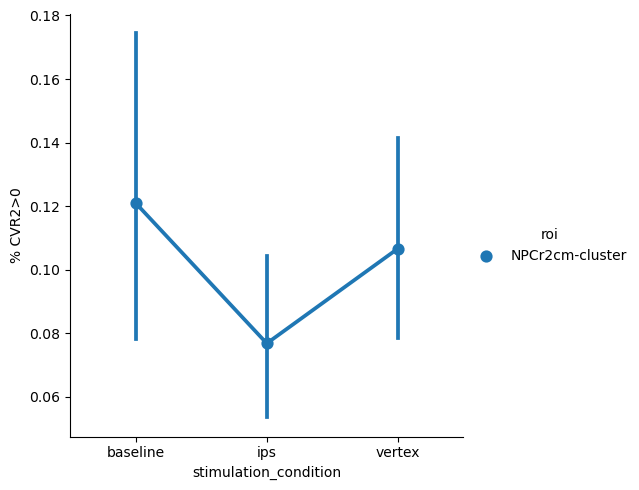

In [6]:
tmp = pars.groupby(['subject', 'stimulation_condition', 'roi']).apply(lambda d: (d['cvr2']>0.0).mean()).to_frame('% CVR2>0')

sns.catplot(x='stimulation_condition', y='% CVR2>0', data=tmp.reset_index(), kind='point', hue='roi', )
tmp

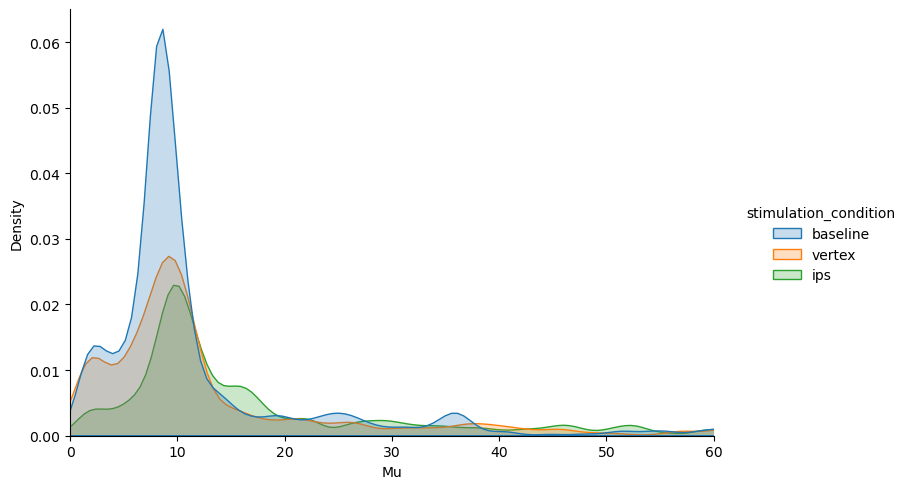

In [7]:
# g = sns.FacetGrid(pars[pars.cvr2 > 0.0].reset_index(), hue='stimulation_condition', height=5, aspect=3.)
# g.map(sns.kdeplot, 'mu', shade=True)
# # g.map(sns.histplot, 'mu')

# # sns.distplot(pars[pars.cvr2>0.0]['mu'])
# g.add_legend()


g = sns.displot(pars[pars.cvr2>0.0].reset_index(), hue='stimulation_condition', x='mu', kind='kde', fill=True, aspect=1.5, bw_adjust=.25)

g.set(xlabel='Mu', xlim=(0, 60))

g.savefig(op.join(bids_folder, 'derivatives', 'figures', 'rf_mu_distribution.pdf'))


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'bins'
  cset = contour_func(


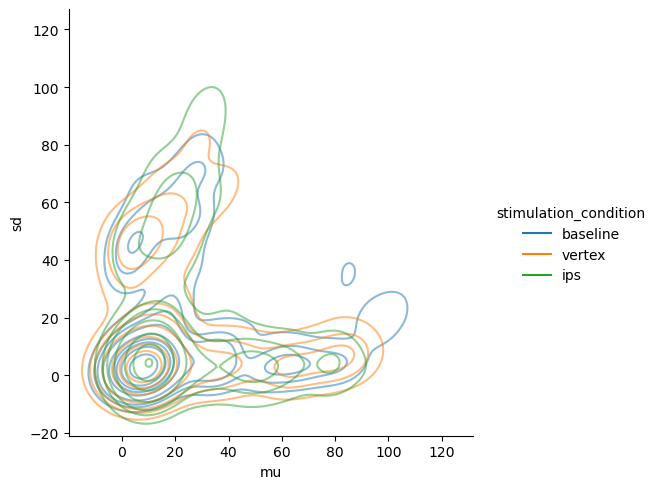

In [8]:
sns.displot(x='mu', y='sd', hue='stimulation_condition', data=pars[pars.cvr2>0.0].reset_index(), bins=20, alpha=.5, kind='kde')

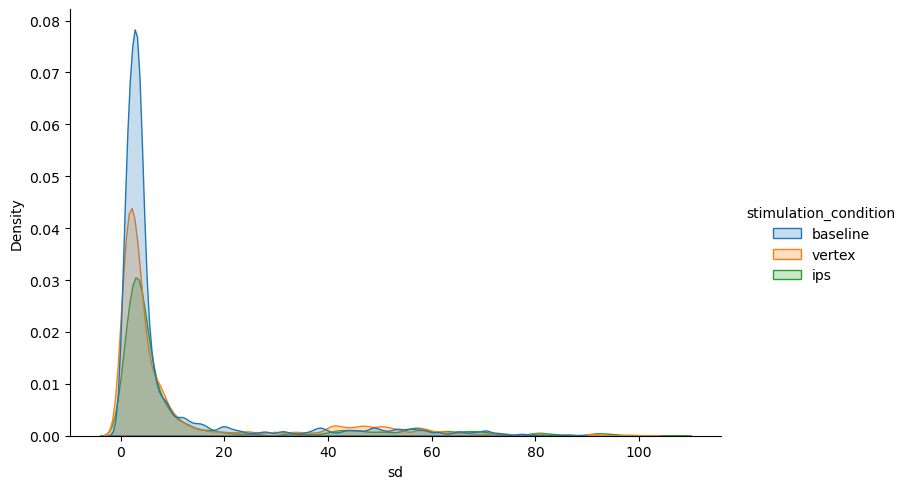

In [20]:
# g = sns.FacetGrid(pars[pars.cvr2 > 0.0].reset_index(), hue='stimulation_condition', height=5, aspect=3.)
# g.map(sns.kdeplot, 'mu', shade=True)
# # g.map(sns.histplot, 'mu')

# # sns.distplot(pars[pars.cvr2>0.0]['mu'])
# g.add_legend()


g = sns.displot(pars[pars.cvr2>0.0].reset_index(), hue='stimulation_condition', x='sd', kind='kde', fill=True, aspect=1.5, bw_adjust=.25)

# g.set(xlabel='Mu', xlim=(0, 60))

g.savefig(op.join(bids_folder, 'derivatives', 'figures', 'rf_sd_distribution.pdf'))


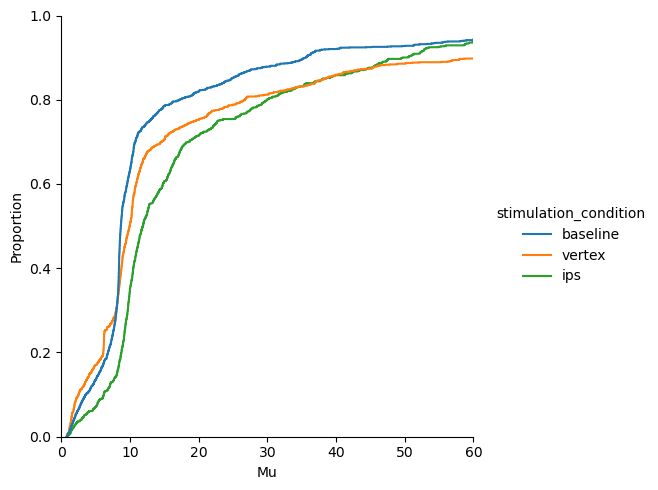

In [18]:
g = sns.displot(pars[pars.cvr2>0.0].reset_index(), hue='stimulation_condition', x='mu', kind='ecdf', )

g.set(xlabel='Mu', xlim=(0, 60))


In [29]:
pars['mu_bin'] = pd.cut(pars['mu'], bins=np.arange(0, 100, 7.5), labels=np.arange(7.5/2., 100, 7.5))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_98172/75121443.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.lineplot(x='mu_bin', y='amplitude', hue='Stimulation condition', data=tmp.reset_index(), ci=68,)


(0.0, 2.0)

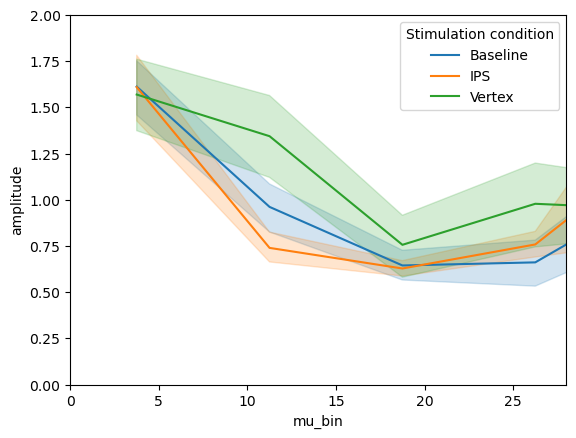

In [55]:
tmp = pars[pars.cvr2 > 0.0].groupby(['subject', 'mu_bin', 'Stimulation condition']).mean()

sns.lineplot(x='mu_bin', y='amplitude', hue='Stimulation condition', data=tmp.reset_index(), ci=68,)

plt.xlim(0, 28)

plt.ylim(0, 2)

(0.0, 50.0)

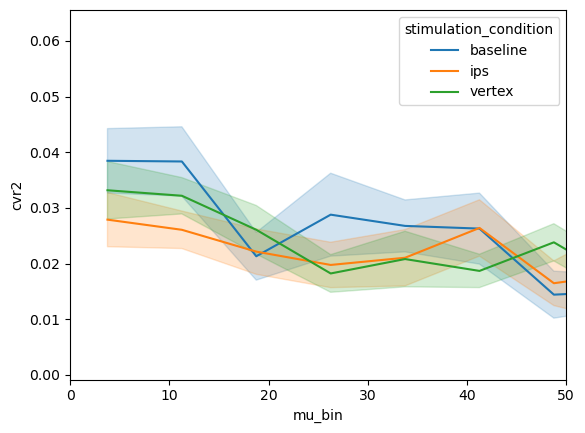

In [46]:
tmp = pars[pars.cvr2 > 0.0].groupby(['subject', 'mu_bin', 'stimulation_condition']).mean()

sns.lineplot(x='mu_bin', y='cvr2', hue='stimulation_condition', data=tmp.reset_index(), errorbar='se')

plt.xlim(0, 50)

# plt.ylim(0, 2)

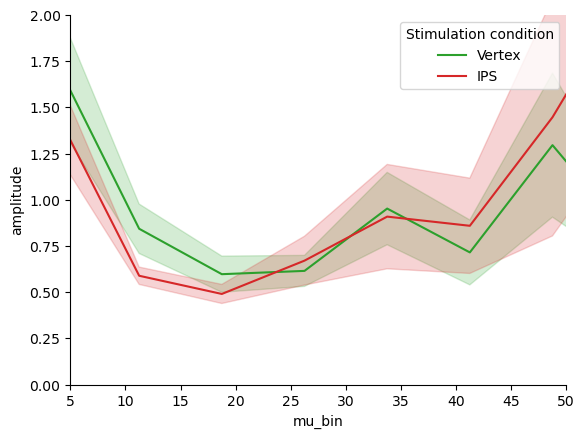

In [70]:
tmp = pars.droplevel('session').droplevel('stimulation_condition').unstack('Stimulation condition')

tmp = tmp[tmp[('cvr2', 'Baseline')] > 0.0]
tmp = tmp.stack('Stimulation condition').groupby(['subject', 'Stimulation condition', 'mu_bin']).mean().drop('Baseline', level='Stimulation condition')

g = sns.lineplot(x='mu_bin', y='amplitude', hue='Stimulation condition', data=tmp.reset_index(), errorbar='se', palette=stimulation_palette, hue_order=stimulation_order)


g.set()

plt.xlim(5, 50)

plt.ylim(0, 2)

sns.despine()

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'rf_amplitude_vs_mu.pdf'))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_73567/1017912580.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.lineplot(x='mu_bin', y='r2', hue='stimulation_condition', data=tmp.reset_index(), ci=68)


(7.0, 28.0)

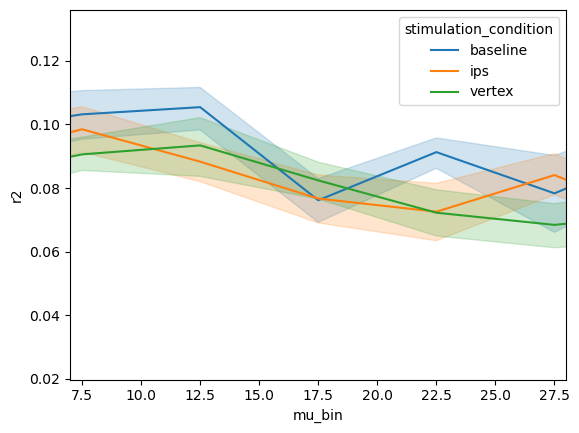

In [10]:
tmp = pars[pars.cvr2 > 0.0].groupby(['subject', 'mu_bin', 'stimulation_condition']).mean()

sns.lineplot(x='mu_bin', y='r2', hue='stimulation_condition', data=tmp.reset_index(), ci=68)

plt.xlim(7, 28)

# plt.ylim(0, 2)

In [11]:
import bambi as bmb 

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [78]:
tmp = pars.drop('baseline', level='stimulation_condition')

tmp = tmp[tmp.cvr2 > 0.0]
tmp = tmp[tmp.mu >= 7]


model = bmb.Model('amplitude ~ bs(mu, df=5)*stimulation_condition + (bs(mu, df=5)*stimulation_condition|subject)', data=tmp.reset_index())


# idata = model.fit()
idata = model.fit(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [amplitude_sigma, Intercept, bs(mu, df=5), stimulation_condition, bs(mu, df=5):stimulation_condition, 1|subject_sigma, 1|subject_offset, bs(mu, df=5)|subject_sigma, bs(mu, df=5)|subject_offset, stimulation_condition|subject_sigma, stimulation_condition|subject_offset, bs(mu, df=5):stimulation_condition|subject_sigma, bs(mu, df=5):stimulation_condition|subject_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 228 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [79]:
predictions = model.predict(idata, inplace=False, kind='pps')

In [80]:
tmp.index.unique(level='stimulation_condition')

Index(['vertex', 'ips'], dtype='object', name='stimulation_condition')

In [86]:
to_predict = pd.MultiIndex.from_product([np.arange(7, 100), ['vertex', 'ips']], names=['mu', 'stimulation_condition']).to_frame()

In [87]:
import arviz as az


def get_hdi(d):
    return az.hdi(d.values, hdi_prob=0.95)

In [88]:
predictions = model.predict(idata, data=to_predict, include_group_specific=False, inplace=False, kind='pps')
predictions = predictions.posterior_predictive.to_dataframe().unstack(['chain', 'draw'])
predictions.index = pd.MultiIndex.from_frame(to_predict)
predictions = predictions.stack([1, 2])

<Axes: xlabel='mu', ylabel='amplitude'>

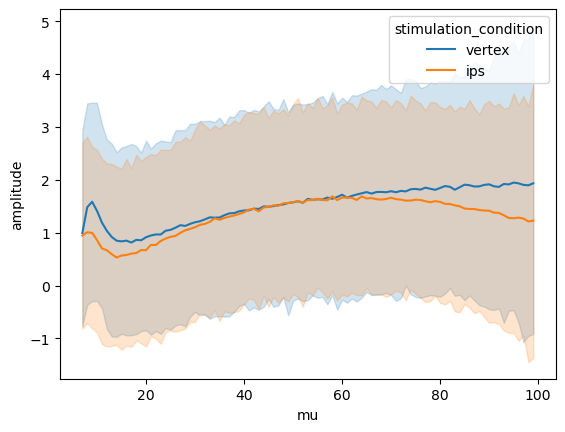

In [89]:
sns.lineplot(x='mu', y='amplitude', hue='stimulation_condition', data=predictions.reset_index(), errorbar=get_hdi)

<Axes: xlabel='mu', ylabel='diff'>

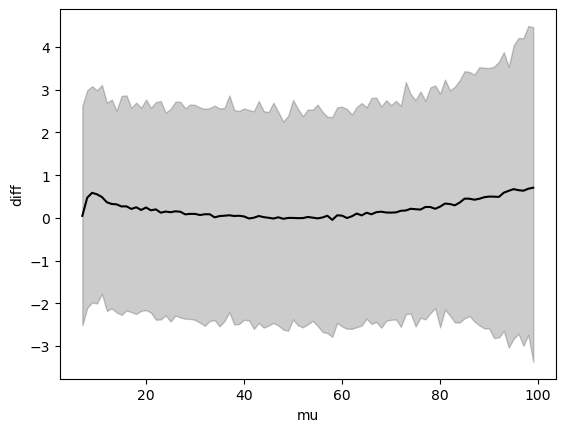

In [91]:
diff = predictions.unstack('stimulation_condition')['amplitude']
diff = (diff['vertex'] - diff['ips']).to_frame('diff')
sns.lineplot(x='mu', y='diff', data=diff.reset_index(), errorbar=get_hdi, color='k')

# plt.ylim(0)

In [93]:
tmp = pars.drop('baseline', level='stimulation_condition')

tmp = tmp[tmp.cvr2 > 0.0]
tmp = tmp[tmp.mu >= 7]


model = bmb.Model('amplitude ~ bs(mu, df=5)*stimulation_condition + (stimulation_condition|subject)', data=tmp.reset_index())


# idata = model.fit()
idata = model.fit(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [amplitude_sigma, Intercept, bs(mu, df=5), stimulation_condition, bs(mu, df=5):stimulation_condition, 1|subject_sigma, 1|subject_offset, stimulation_condition|subject_sigma, stimulation_condition|subject_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 61 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [94]:
predictions = model.predict(idata, data=to_predict, include_group_specific=False, inplace=False, kind='pps')
predictions = predictions.posterior_predictive.to_dataframe().unstack(['chain', 'draw'])
predictions.index = pd.MultiIndex.from_frame(to_predict)
predictions = predictions.stack([1, 2])

<Axes: xlabel='mu', ylabel='amplitude'>

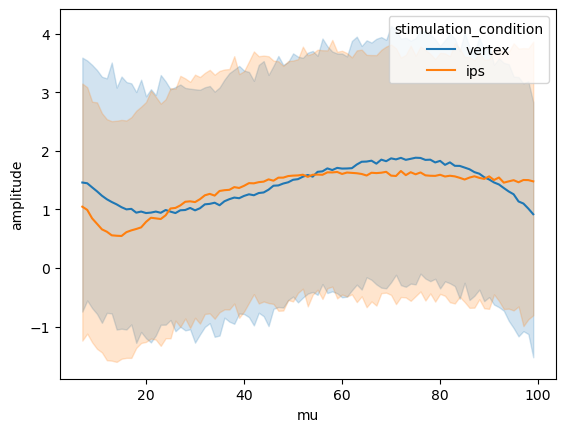

In [95]:
sns.lineplot(x='mu', y='amplitude', hue='stimulation_condition', data=predictions.reset_index(), errorbar=get_hdi)

<Axes: xlabel='mu', ylabel='diff'>

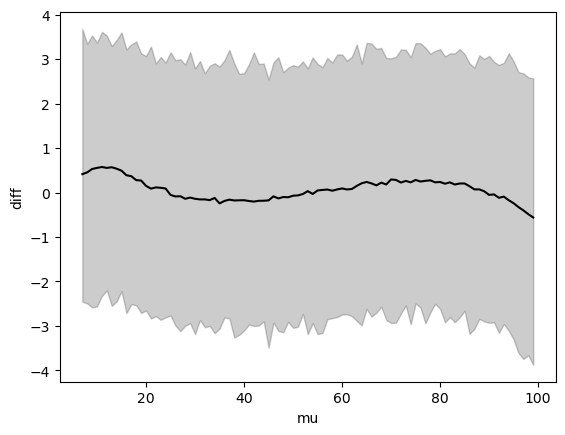

In [96]:
diff = predictions.unstack('stimulation_condition')['amplitude']
diff = (diff['vertex'] - diff['ips']).to_frame('diff')
sns.lineplot(x='mu', y='diff', data=diff.reset_index(), errorbar=get_hdi, color='k')

# plt.ylim(0)

In [114]:
tmp = pars.drop('baseline', level='stimulation_condition')

tmp = tmp[tmp.cvr2 > 0.0]
tmp = tmp[(tmp.mu >= 7) & (tmp.mu < 28)]

tmp = tmp.groupby(['subject', 'mu_bin', 'stimulation_condition']).mean().reset_index()
tmp['mu_bin'] = tmp['mu_bin'].astype(float)

tmp = tmp[~tmp['amplitude'].isnull()]


model = bmb.Model('amplitude ~ bs(mu_bin, df=5)*stimulation_condition + (stimulation_condition|subject)', data=tmp.reset_index())


# idata = model.fit()
idata = model.fit(cores=1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [amplitude_sigma, Intercept, bs(mu_bin, df=5), stimulation_condition, bs(mu_bin, df=5):stimulation_condition, 1|subject_sigma, 1|subject_offset, stimulation_condition|subject_sigma, stimulation_condition|subject_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 59 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [118]:
to_predict = pd.MultiIndex.from_product([np.arange(7.5, 28), ['vertex', 'ips']], names=['mu_bin', 'stimulation_condition']).to_frame()

In [119]:
predictions = model.predict(idata, data=to_predict, include_group_specific=False, inplace=False, kind='pps')
predictions = predictions.posterior_predictive.to_dataframe().unstack(['chain', 'draw'])
predictions.index = pd.MultiIndex.from_frame(to_predict)
predictions = predictions.stack([1, 2])

<Axes: xlabel='mu_bin', ylabel='amplitude'>

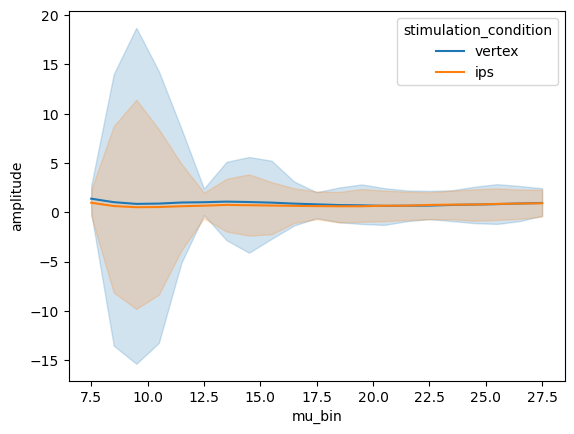

In [120]:
sns.lineplot(x='mu_bin', y='amplitude', hue='stimulation_condition', data=predictions.reset_index(), errorbar=get_hdi)

<Axes: xlabel='mu_bin', ylabel='amplitude'>

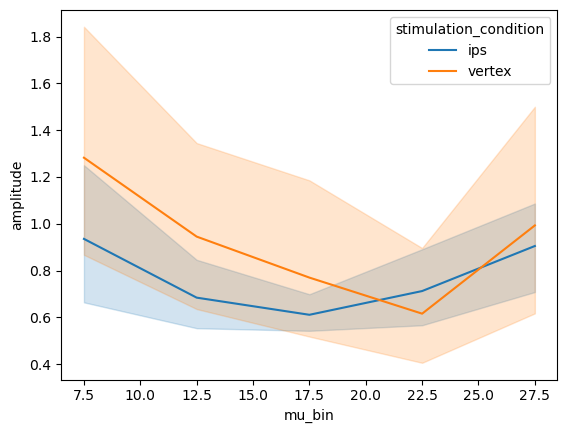

In [121]:
sns.lineplot(x='mu_bin', y='amplitude', data=tmp.reset_index(), hue='stimulation_condition')

In [126]:
dir(model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_added_priors',
 '_build_priors',
 '_check_built',
 '_formula',
 '_set_family',
 '_set_priors',
 'auto_scale',
 'backend',
 'build',
 'built',
 'center_predictors',
 'components',
 'constant_components',
 'data',
 'distributional_components',
 'dropna',
 'family',
 'fit',
 'formula',
 'graph',
 'noncentered',
 'plot_priors',
 'potentials',
 'predict',
 'prior_predictive',
 'response_component',
 'response_name',
 'scaler',
 'set_alias',
 'set_priors']

In [128]:
dir(model.formula)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'additionals',
 'additionals_lhs',
 'check_additional',
 'check_additionals',
 'get_all_formulas',
 'main']